Import basic stuff

In [1]:
%matplotlib inline

import os
import sys
import settings
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
import django
os.environ.setdefault('DJANGO_SETTINGS_MODULE', 'rest.settings')
os.environ["DJANGO_ALLOW_ASYNC_UNSAFE"] = "true"
django.setup()

In [3]:
sid = 500820
from stocks.models import Listing, Stock

In [20]:
stock = Stock.objects.get(security=sid)
print(stock)

ASIAN PAINTS LTD.


In [21]:
listings = Listing.objects.filter(stock=stock)
print(len(listings))

5322


Transorm the data for plotting

In [6]:
dates = list(map(lambda d: d.date.date(), listings))

In [7]:
closing = list(map(lambda d:d.closing, listings))

In [113]:
from django_pandas.io import read_frame
df = read_frame(listings, index_col='date')

In [114]:
for column in df.columns:
    if column is not 'stock':
       df[column] = pd.to_numeric(df[column]) 

In [115]:
df = df.sort_index()
df.columns

Index(['id', 'opening', 'high', 'low', 'closing', 'wap', 'traded', 'trades',
       'turnover', 'deliverable', 'ratio', 'spread_high_low',
       'spread_close_open', 'stock'],
      dtype='object')

In [116]:
df = df.reindex(columns = ['opening', 'high', 'low', 'closing', 'traded'])
df.rename(columns={"opening": "Open", "high": "High", "low": "Low", "closing":"Close", "traded":"Volume"}, inplace=True)

In [117]:
df = df.loc['2020-10-13':'2021-12-31']

<AxesSubplot:xlabel='date'>

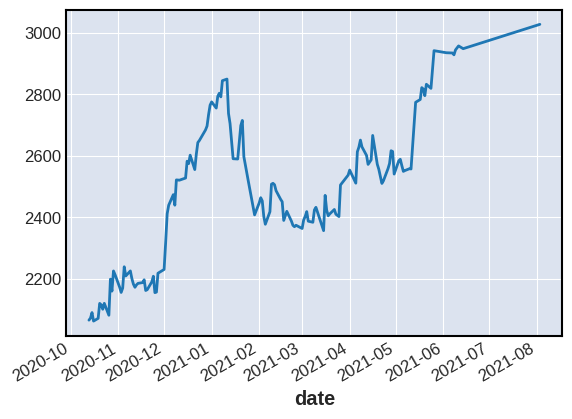

In [118]:
df['Close'].plot()

* Load up minutewise data of Nifty
* Chop it into baskets of days
* For each day, find the maximum and also the hover levels at around 1:00pm
* Hypotheses is that Short Covering happens nearly every day around 1pm, or 2pm - and particularly on days where morning half sees a good upward rally and little downward rally.
* So, if morning has been in strong uptrend, what is the statistical frequency of a 'significant' short-covering
* With entry around 1/1:15pm at spot, how many point movement can be expected?
* What should be the stop-loss?

Try to find the local maxima and minima for finding support and resistance.

[Link](https://towardsdatascience.com/detection-of-price-support-and-resistance-levels-in-python-baedc44c34c9)

In [119]:
from mplfinance.original_flavor import candlestick_ohlc
import matplotlib.dates as mpl_dates
plt.rcParams['figure.figsize'] = [12, 7]
plt.rc('font', size=14)

In [120]:
df.index = pd.to_datetime(df.index)
df.tail()

,Open,High,Low,Close,Volume
date,,,,,
2021-06-08,2922.70,2944.65,2906.90,2928.1,73054
2021-06-09,2936.00,2964.95,2920.40,2944.1,124701
2021-06-11,2969.00,2969.95,2939.20,2957.1,58856
2021-06-14,2961.95,2970.00,2916.55,2948.1,33431
2021-08-03,3010.00,3064.95,2996.95,3027.3,104743


In [121]:
#Try to find support and resistance by identifying the fractal pattern.
def isSupport(df,i):
  support = df['Low'][i] < df['Low'][i-1]  and df['Low'][i] < df['Low'][i+1] and df['Low'][i+1] < df['Low'][i+2] and df['Low'][i-1] < df['Low'][i-2]
  return support

def isResistance(df,i):
  resistance = df['High'][i] > df['High'][i-1]  and df['High'][i] > df['High'][i+1] and df['High'][i+1] > df['High'][i+2] and df['High'][i-1] > df['High'][i-2]
  return resistance

In [122]:
levels = []
for i in range(2,df.shape[0]-2):
  if isSupport(df,i):
    levels.append((i,df['Low'][i]))
  elif isResistance(df,i):
    levels.append((i,df['High'][i]))

In [123]:
def plot_all(df, levels):
  fig, ax = plt.subplots()
  candlestick_ohlc(ax,df.values,width=0.6, \
                   colorup='green', colordown='red', alpha=0.8)
  date_format = mpl_dates.DateFormatter('%d %b %Y')
  ax.xaxis.set_major_formatter(date_format)
  fig.autofmt_xdate()
  fig.tight_layout()
  for level in levels:
    plt.hlines(level[1],xmin=df['date'][level[0]],\
               xmax=max(df['date']),colors='blue')
  fig.show()

In [124]:
from matplotlib.dates import date2num
df_1 = df.reset_index()
df_1['date'] = date2num(df_1['date'])
df_1.head()

,date,Open,High,Low,Close,Volume
0,18548.0,2072.00,2112.90,2054.40,2064.75,48983
1,18549.0,2066.05,2084.35,2055.15,2071.30,53116
2,18550.0,2077.60,2122.80,2069.45,2089.40,203353
3,18551.0,2090.50,2090.50,2057.00,2061.75,29573
4,18554.0,2070.10,2076.65,2056.25,2070.60,41532


/home/anshul/web/experimental/env/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  if sys.path[0] == '':


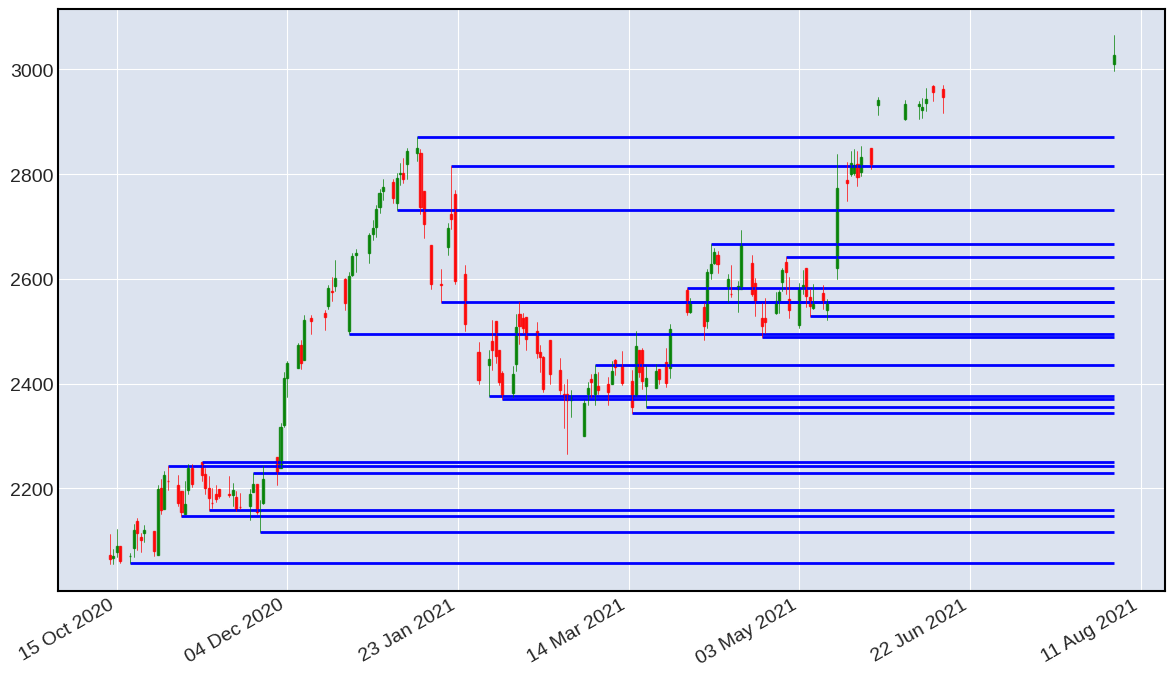

In [125]:
plot_all(df_1, levels)

In [126]:
def isFarFromLevel(l, margin, levels):
  return np.sum([abs(l-x) < margin  for x in levels]) == 0

In [127]:
margin =  np.mean(df_1['High'] - df_1['Low'])

In [128]:
levels = []
for i in range(2,df_1.shape[0]-2):
  if isSupport(df_1,i):
    l = df['Low'][i]

    if isFarFromLevel(l, margin, levels):
      levels.append((i,l))

  elif isResistance(df_1,i):
    l = df['High'][i]

    if isFarFromLevel(l, margin, levels):
      levels.append((i,l))

/home/anshul/web/experimental/env/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  if sys.path[0] == '':


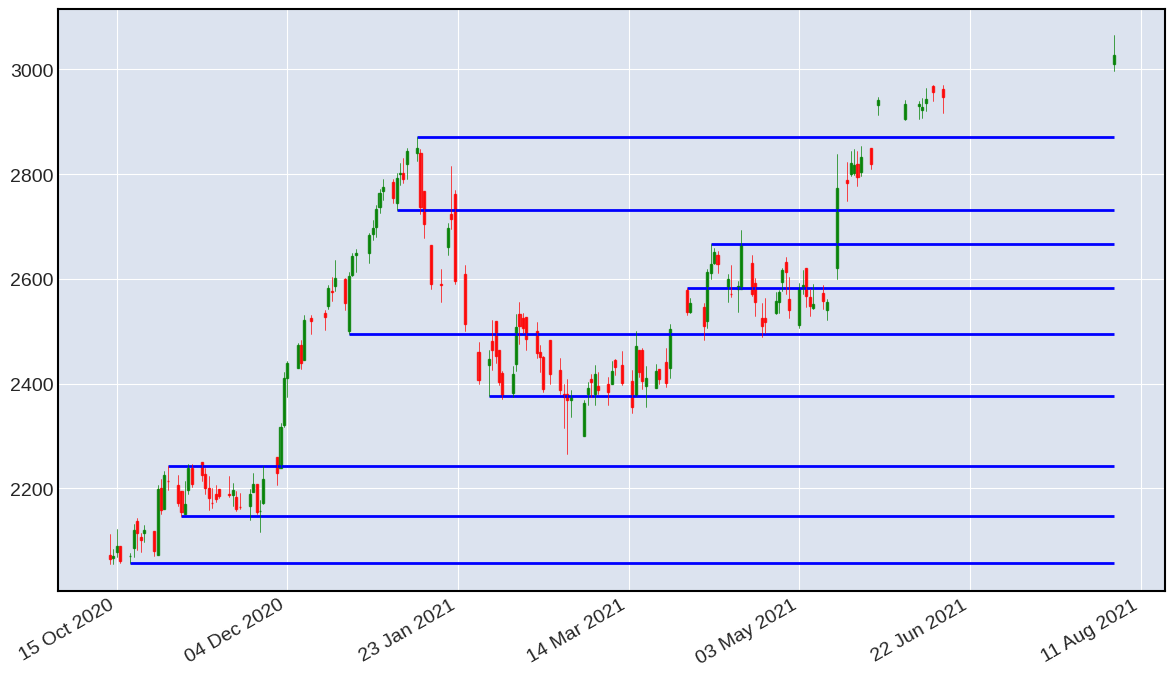

In [129]:
plot_all(df_1, levels)

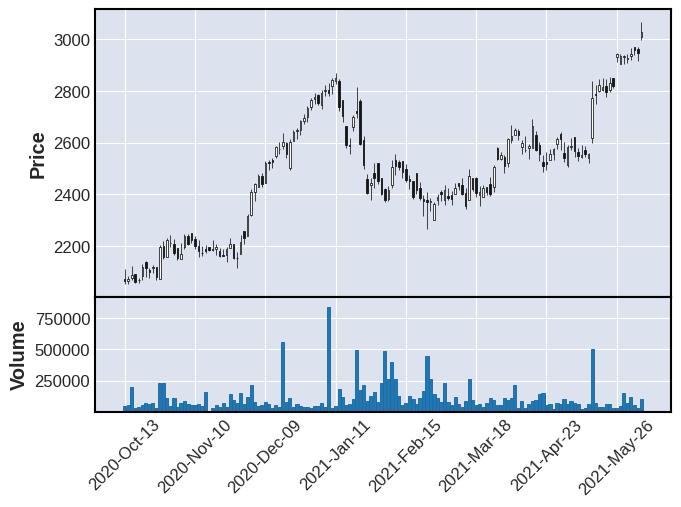

In [130]:
df_2 = df.loc['2020-10-13':'2021-12-31']
mpf.plot(df_2,type='candle', volume=True)

In [ ]:
def ma(type='SMA', length=20, df=None):
    if df=None:
        print('Dataframe not provided.')
        return None
    if type=='SMA':
        df['SMA'+str(length)]=df['Close'].rolling(length).mean()
        df.dropna(inplace=True)
    elif type=='EMA':
        df['SMA'+str(length)]=df['Close'].ewm(span=length).mean()
        df.dropna(inplace=True)
    return df
        
    

In [133]:
#Compute moving averages
df['SMA20'] = df['Close'].rolling(30).mean()
# removing all the NULL values using 
# dropna() method
df.dropna(inplace=True)

In [134]:
df['EMA20'] = df['Close'].ewm(span=30).mean()
df.dropna(inplace=True)